In [1]:
import pandas as pd
import numpy as np
import folium
from datetime import datetime, timedelta

# 1. Creiamo dati fittizi ma realistici per il Golfo Persico
# Coordinate approssimative dello Stretto di Hormuz: 26.5N, 56.5E
np.random.seed(42)
n_navi = 50

data = {
    'mmsi': range(1000, 1000 + n_navi),
    'lat': np.random.uniform(25.5, 27.5, n_navi),
    'lon': np.random.uniform(54.5, 57.5, n_navi),
    'tipo': np.random.choice(['mercantile', 'petroliera', 'militare'], n_navi, p=[0.4, 0.4, 0.2]),
    'velocita': np.random.uniform(5, 20, n_navi)
}

df = pd.DataFrame(data)

# 2. Visualizzazione su Mappa
mappa = folium.Map(location=[26.5, 56.0], zoom_start=7, tiles='CartoDB dark_matter')

for _, nave in df.iterrows():
    colore = 'red' if nave['tipo'] == 'militare' else 'blue'
    folium.CircleMarker(
        location=[nave['lat'], nave['lon']],
        radius=5,
        color=colore,
        fill=True,
        popup=f"Tipo: {nave['tipo']} - Vel: {nave['velocita']:.1f} nodi"
    ).add_to(mappa)

mappa

In [2]:
from scipy.spatial.distance import cdist

def calcola_indice_rischio(df):
    # Separiamo civili e militari
    civili = df[df['tipo'] != 'militare'][['lat', 'lon']].values
    militari = df[df['tipo'] == 'militare'][['lat', 'lon']].values
    
    # Calcoliamo la distanza minima per ogni nave civile verso una militare
    # (Distanza euclidea semplificata per l'esempio)
    distanze = cdist(civili, militari)
    min_distanze = distanze.min(axis=1)
    
    # Definiamo un rischio: più la distanza è piccola, più il rischio aumenta
    # Es: Rischio alto se sotto i 0.5 gradi di distanza (circa 50km)
    rischio_medio = np.mean(min_distanze < 0.5) * 100
    
    print(f"--- REPORT DI SICUREZZA MARITTIMA ---")
    print(f"Data analisi: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f"Percentuale navi civili in zona di prossimità militare: {rischio_medio:.1f}%")
    
    return rischio_medio

indice = calcola_indice_rischio(df)

--- REPORT DI SICUREZZA MARITTIMA ---
Data analisi: 2026-01-29 22:10
Percentuale navi civili in zona di prossimità militare: 86.5%


Cartella ../reports creata con successo!


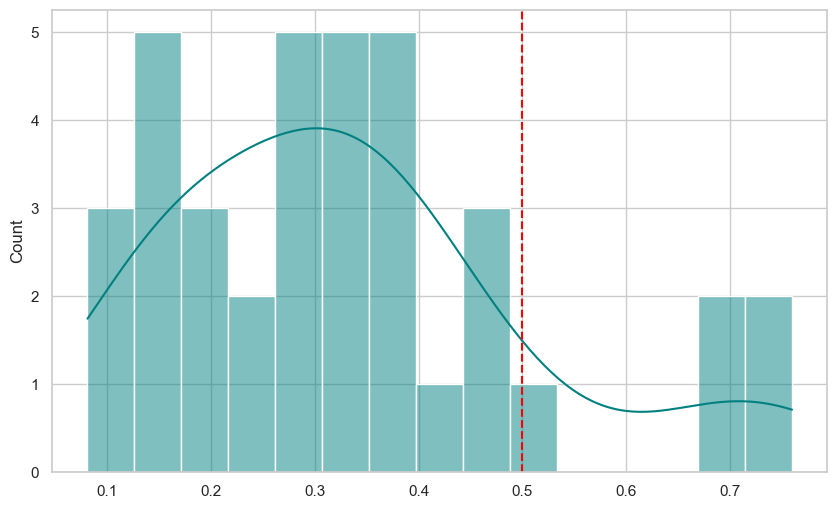

In [5]:
import os # Importiamo il modulo per gestire il sistema operativo

def genera_grafico_distanze(df):
    # --- Codice precedente per il calcolo delle distanze ---
    civili = df[df['tipo'] != 'militare'][['lat', 'lon']].values
    militari = df[df['tipo'] == 'militare'][['lat', 'lon']].values
    distanze = cdist(civili, militari).min(axis=1)

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    sns.histplot(distanze, kde=True, color="teal", bins=15)
    plt.axvline(x=0.5, color='red', linestyle='--', label='Soglia di Allerta')
    
    # --- CORREZIONE ERRORE ---
    output_dir = '../reports'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Cartella {output_dir} creata con successo!")
    
    plt.savefig(f'{output_dir}/distribuzione_rischio.png')
    plt.show()

genera_grafico_distanze(df)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def simula_evoluzione_temporale(ore=24):
    storia_rischio = []
    
    # Stato iniziale (usiamo il df creato prima)
    # Creiamo una copia per non sporcare i dati originali
    df_dinamico = df.copy()
    
    for ora in range(ore):
        # Simula movimento: le navi militari si spostano leggermente
        # (Aggiungiamo un piccolo 'drift' verso il centro per simulare concentrazione)
        df_dinamico.loc[df_dinamico['tipo'] == 'militare', 'lat'] += np.random.normal(-0.02, 0.01)
        df_dinamico.loc[df_dinamico['tipo'] == 'militare', 'lon'] += np.random.normal(-0.02, 0.01)
        
        # Calcolo rischio (come prima)
        civili = df_dinamico[df_dinamico['tipo'] != 'militare'][['lat', 'lon']].values
        militari = df_dinamico[df_dinamico['tipo'] == 'militare'][['lat', 'lon']].values
        distanze = cdist(civili, militari).min(axis=1)
        
        # Indice di rischio: % di navi sotto la soglia di 0.3 gradi (circa 30km)
        rischio = (np.sum(distanze < 0.3) / len(civili)) * 100
        storia_rischio.append(rischio)
        
    return storia_rischio

# Esecuzione
dati_cronologici = simula_evoluzione_temporale()

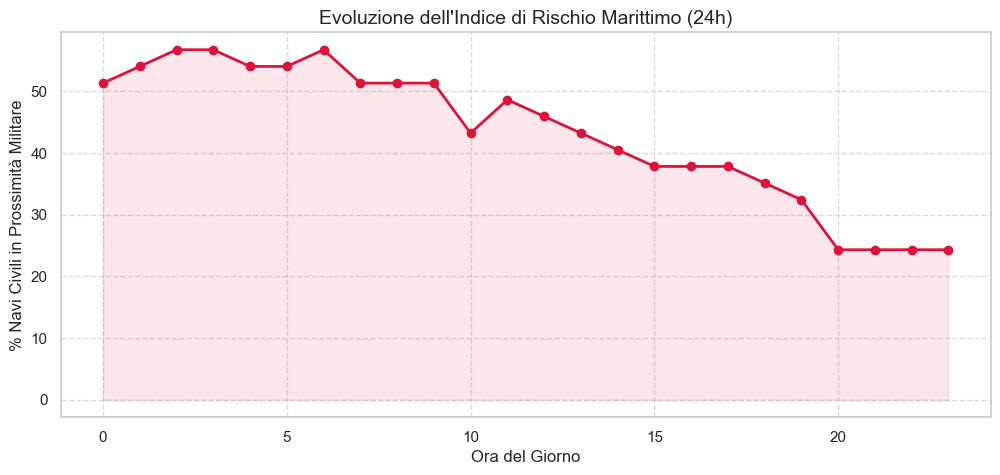

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(range(24), dati_cronologici, marker='o', color='crimson', linewidth=2)
plt.fill_between(range(24), dati_cronologici, color='crimson', alpha=0.1)

plt.title('Evoluzione dell\'Indice di Rischio Marittimo (24h)', fontsize=14)
plt.xlabel('Ora del Giorno', fontsize=12)
plt.ylabel('% Navi Civili in Prossimità Militare', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Salvataggio automatico nel report
plt.savefig('../reports/trend_rischio_24h.png')
plt.show()

In [9]:
from folium.plugins import HeatMap

# 1. Prepariamo i dati per la Heatmap
# La HeatMap di Folium accetta una lista di [lat, lon, weight]
dati_heatmap = df[['lat', 'lon']].values.tolist()

# 2. Creiamo la mappa base centrata sullo Stretto
m_heat = folium.Map(location=[26.5, 56.0], zoom_start=7, tiles='CartoDB dark_matter')

# 3. Aggiungiamo lo strato di calore
HeatMap(dati_heatmap, radius=15, blur=20, min_opacity=0.5).add_to(m_heat)

# 4. Aggiungiamo i marker delle navi militari come punti di riferimento critici
for _, nave in df[df['tipo'] == 'militare'].iterrows():
    folium.Marker(
        location=[nave['lat'], nave['lon']],
        icon=folium.Icon(color='red', icon='warning', prefix='fa'),
        popup="Unità Militare - Centro di Pressione"
    ).add_to(m_heat)

# Salva la mappa come file HTML interattivo per il report
output_map = '../reports/mappa_calore_rischio.html'
m_heat.save(output_map)

m_heat